In [1]:
# LangGraph agentic AI pipeline for structured data analysis
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langgraph.graph import StateGraph, END, START
import os
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
import os
from dotenv import load_dotenv
from tqdm.autonotebook import tqdm as notebook_tqdm
from typing import TypedDict, Literal
from pydantic import BaseModel
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from typing import Annotated
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from IPython.display import display, Image, Markdown
from langgraph.graph import StateGraph, START, END, MessagesState
from pydantic import BaseModel, Field 



/var/folders/2l/h792r8g56wx6dpj_tzgmky7m0000gn/T/ipykernel_18833/403862728.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as notebook_tqdm


In [2]:

## Load environment variables
load_dotenv()
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

In [3]:
import pandas as pd
import sqlite3

def csv_to_sqlite(csv_file_path, sqlite_db_path, table_name):
    # Load CSV into DataFrame
    df = pd.read_csv(csv_file_path)

    # Connect to SQLite database (creates it if it doesn't exist)
    conn = sqlite3.connect(sqlite_db_path)

    # Write the DataFrame to SQLite table
    df.to_sql(table_name, conn, if_exists='replace', index=False)

    # Close the connection
    conn.close()

    print(f"CSV '{csv_file_path}' has been imported into SQLite DB '{sqlite_db_path}' as table '{table_name}'.")




In [4]:
csv_to_sqlite('customer_features_long_format.csv', 'nqes.db', 'customer_features_long_format')
csv_to_sqlite('customer_scores_long_format.csv', 'nqes.db', 'customer_scores_long_format')

CSV 'customer_features_long_format.csv' has been imported into SQLite DB 'nqes.db' as table 'customer_features_long_format'.
CSV 'customer_scores_long_format.csv' has been imported into SQLite DB 'nqes.db' as table 'customer_scores_long_format'.


In [6]:
# Load LLM
load_dotenv()
llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY_3") ,model="openai/gpt-oss-120b", temperature=0)
# llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY_2") ,model="llama3-70b-8192", temperature=0)

response = llm.invoke("Hello, just testing.")
print(response)

content='Hello! 👋 How can I help you today?' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 76, 'total_tokens': 120, 'completion_time': 0.088652629, 'prompt_time': 0.002696262, 'queue_time': 0.053444708, 'total_time': 0.091348891}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a09bde29de', 'finish_reason': 'stop', 'logprobs': None} id='run-6ce31a22-e796-4b58-bdec-009629cb22df-0' usage_metadata={'input_tokens': 76, 'output_tokens': 44, 'total_tokens': 120}


In [7]:
# ## https://openrouter.ai/models?q=free
# from langchain.chat_models import ChatOpenAI
# load_dotenv()
# llm = ChatOpenAI(
#     model_name="openai/gpt-oss-20b:free",
#     openai_api_key=os.getenv("OPENROUTER_API_KEY"),
#     openai_api_base="https://openrouter.ai/api/v1"
# )
# response = llm.invoke("Hello, just testing.")
# print(response)

In [8]:
# Load SQLite DB

SQL_PREFIX = """You are an agent for interacting with a SQLite database.

Schema:
  customer_features_long_format(
    customer_id TEXT NOT NULL,
    feature_name TEXT NOT NULL,
    feature_value REAL NOT NULL
  )

  customer_scores_long_format(
    customer_id TEXT NOT NULL,
    score_name TEXT NOT NULL,
    score_value REAL NOT NULL
  )

Instructions:
- For any input, write a valid SQLite SELECT query only. Return the raw query text (e.g., SELECT ...), with no formatting, code blocks, or explanations. Never generate DML (INSERT, UPDATE, DELETE, DROP).
- Do not limit results unless the user explicitly asks for a specific number.
- Always start by inspecting the tables and schema, then query the relevant ones.
- Double-check queries before execution. If an error occurs, correct and retry.
- Only use the provided tools and the information they return.
- In the final answer, output the complete results in Markdown table format. Escape special characters correctly (e.g., $25.5 → $25.5).
"""


SYS_PROMPT = SystemMessage(content=SQL_PREFIX)

db = SQLDatabase.from_uri("sqlite:///nqes.db")
sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = sql_toolkit.get_tools()

text2sql_agent = create_react_agent(model=llm,
                                    tools=sql_tools,
                                    state_modifier=SYS_PROMPT)

In [9]:
# create node function for researcher sub-agent
def research_node(state: MessagesState) -> Command[Literal["validator"]]:
    result = text2sql_agent.invoke(state)
    print(f"--- Workflow Transition: Researcher → Validator ---")
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="validator",
    )

In [10]:
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute code, generate charts."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nCODE OUTPUT:\n {result}"
    return result_str

# Create Coder Sub-Agent
code_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier="""You are a coder who can write and run python code and also visualize charts and graphs.
                                                                                 Extract entire data related to the question before running code or creating graphs.
                                                                                 For fetching data from the database, use the researcher agent.
                                                                                 Use the python repl tool to execute code and generate charts.
                                                                                 Once your task is done report back to the supervisor.""")

def code_node(state: MessagesState) -> Command[Literal["validator"]]:
    result = code_agent.invoke(state)
    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator",
    )


In [11]:
def insights_generator_node(state: MessagesState) -> Command[Literal["validator"]]:
    # Extract researcher message
    researcher_output = next((msg.content for msg in state["messages"] if msg.name == "researcher"), None)
    if not researcher_output:
        return Command(update={"messages": [HumanMessage(content="No researcher data found.", name="insights_generator")]}, goto="supervisor")

    # Construct dynamic prompt
    insight_prompt = f"""
Act as a Customer Experience Analyst, responsible for interpreting and communicating complex data insights to stakeholders.
Given the following Customer ID, KPI values, SHAP values, and scores for a customer ,
provide a natural language summary explaining why the customer's experience score is the way it is.

          **Customer Experience Score Breakdown:**

                - **Overall Experience Score:** [main_score] (1-10, higher is better)
                - **Subscores:**
                - **Signal Quality:** [signal_quality_subscore] (1-10, higher is better)
                - **KPI Values:**
                - **Reference Signal Received Power:** [rsrp]
                - **Signal to Interference plus Noise Ratio:** [sinr]
                - **SHAP Values:**
                - **Reference Signal Received Power SHAP value:** [shap_rsrp]
                - **Signal to Interference plus Noise Ratio SHAP value:** [shap_sinr]

          Refer to these for Customer ID, KPI values, SHAP values, and scores:
          {researcher_output}

**Your Task:**
- Explain which KPIs are positively or negatively contributing to the experience score.
- Determine whether SHAP values align with KPI values.
- Identify the main reasons for a high or low score.
- Point out any discrepancies between SHAP and KPI values.
- Provide clear, actionable insights understandable to non-technical stakeholders.
"""

    result = llm.invoke([HumanMessage(content=insight_prompt)])
    print(f"--- Workflow Transition: Coder → Insights Generator ---")
    return Command(
        update={"messages": [HumanMessage(content=result.content, name="insights_generator")]},
        goto="validator",
    )

    

In [12]:

system_prompt = '''
    Your task is to ensure quality control. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    
    Routing Guidelines:
    1. If the answer **does not fully satisfy all major parts of the question** (e.g., missing required plots, calculations, or steps), route back to the supervisor.
    2. Only respond with 'FINISH' if the answer fully addresses the question.
    3. Do not accept partially correct answers as "good enough" if the user explicitly asked for multiple deliverables (e.g., values AND charts).
    4. Continue to ignore minor formatting/style issues.
'''

class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END  
        print(" --- Transitioning to END ---")  
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
 

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto, 
    )

In [13]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
   
    system_prompt = (
        "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key intent and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
    )

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]  

    enhanced_query = llm.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [  
                HumanMessage(
                    content=enhanced_query.content, 
                    name="enhancer"  
                )
            ]
        },
        goto="supervisor", 
    )

In [14]:
# class Supervisor(BaseModel):
#     next: Literal["enhancer", "researcher", "coder"] = Field(
#         description="Determines which specialist to activate next in the workflow sequence: "
#                     "'enhancer' when user input requires clarification, expansion, or refinement, "
#                     "'researcher' when data collection is needed from the SQLite Database is necessary, "
#                     "'coder' when writing and running the python code for chart generation and visualizations, or technical problem-solving is required."
#     )
#     reason: str = Field(
#         description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
#     )

# def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:
#     members = ["enhancer", "researcher", "coder"]
#     system_prompt = (f'''
                 
#         You are a workflow supervisor managing a team of three specialized agents: {members}. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

#         **Team Members**:
#         1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
#         2. **Researcher**: Specializes in SQL querying on structured customer experience data and collecting relevant data needed to address the user's request. The researcher does not write code.
#         3. **Coder**: Focuses on writing and running the python code for chart generation, visualizations, data analysis and coding solutions.

#         **Your Responsibilities**:
#         1. Analyze each user request and agent response for completeness, accuracy, and relevance.
#         2. Route the task to the most appropriate agent at each decision point.
#         3. Maintain workflow momentum by avoiding redundant agent assignments.
#         4. Continue the process until the user's request is fully and satisfactorily resolved.

#         Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
#     ''')
    
#     messages = [
#         {"role": "system", "content": system_prompt},  
#     ] + state["messages"] 

#     response = llm.with_structured_output(Supervisor).invoke(messages)

#     goto = response.next
#     reason = response.reason

#     # print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    
#     return Command(
#         update={
#             "messages": [
#                 HumanMessage(content=reason, name="supervisor")
#             ]
#         },
#         goto=goto,  
#     )

In [15]:
class Supervisor(BaseModel):
    next: Literal["enhancer", "researcher", "coder","insights_generator","FINISH"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'enhancer' when user input requires clarification, expansion, or refinement, "
                    "'researcher' when data collection is needed from the SQLite Database is necessary, "
                    "'coder' when writing and running the python code for chart generation and visualizations, or technical problem-solving is required."
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder","insights_generator","__end__"]]:
    members = ["enhancer", "researcher", "coder","insights_generator"]
    system_prompt = (f'''
                 
        You are a workflow supervisor managing a team of three specialized agents: {members}. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
        2. **Researcher**: Specializes in SQL querying on structured customer experience data and collecting relevant data needed to address the user's request. The researcher does not write code.
        3. **Coder**: Focuses on writing and running the python code for chart generation, visualizations, data analysis and coding solutions.
        4. **Insights Generator**: Focuses on interpreting and summarizing complex data insights into actionable recommendations for stakeholders.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.
        5. If the user query is disrespectful, rude, offensive, or insulting → 
            Set next="FINISH" and reason="Supervisor Message: Your query seems disrespectful. Please rephrase respectfully."
        6. If the query is about general knowledge, education, or outside the scope of structured customer SQL data →
            Set next="FINISH" and reason="This is a general knowledge or educational query. I can only help with structured customer data."
    

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
    ''')
    
    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 

    response = llm.with_structured_output(Supervisor).invoke(messages)
    try:
        goto = response.next
        reason = response.reason
        # ✅ DEBUG PRINT HERE
        print(f"\n🔍 Routed Agents: {goto}")
        if reason:
            print(f"📩 Supervisor Message: {reason}\n")
    except Exception:
        # fallback safe default
        goto = "FINISH"
        message = "This seems to be a general knowledge or unsupported question. I can only help with structured customer data."

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    update = {"next": goto}
    if reason:
        update["reason"] = state["messages"] + [{"role": "system", "content": reason}]

    return Command(goto=END if goto == "FINISH" else goto, update=update)


    # return Command(
    #     update={
    #         "messages": [
    #             HumanMessage(content=reason, name="supervisor")
    #         ]
    #     },
    #     goto=goto,  
    # )

In [16]:
graph = StateGraph(MessagesState)

# Add all nodes
graph.add_node("supervisor", supervisor_node)
graph.add_node("enhancer", enhancer_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)
graph.add_node("insights_generator", insights_generator_node)
graph.add_node("validator", validator_node)

# Set entry point
graph.add_edge(START, "supervisor")

# Compile into app
app = graph.compile()

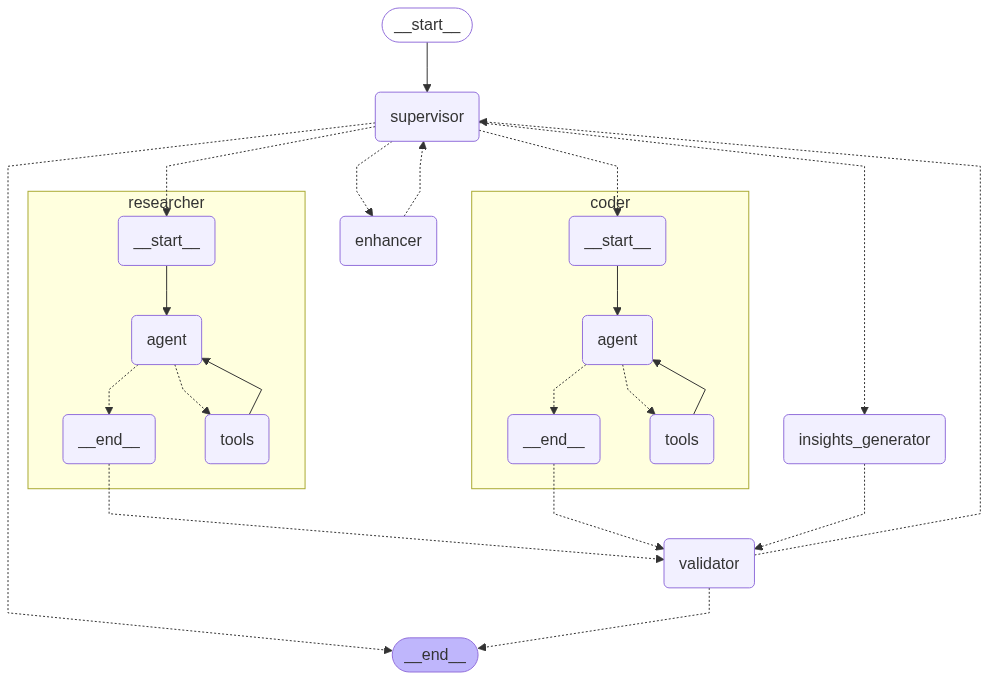

In [17]:
from IPython.display import display, Image

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [18]:
def call_multi_agent_system(agent, prompt):
    events = agent.stream(
        {"messages": [("user", prompt)]},
        {"recursion_limit": 150},
        stream_mode="values",

    )

    for event in events:
        event["messages"][-1].pretty_print()

    display(Markdown(event["messages"][-1].content))

In [421]:
call_multi_agent_system(app, "are you an idiot?")


================================ Human Message =================================

are you an idiot?

🔍 Routed Agents: FINISH
📩 Supervisor Message: Supervisor Message: Your query seems disrespectful. Please rephrase respectfully.

--- Workflow Transition: Supervisor → FINISH ---


are you an idiot?

In [285]:
call_multi_agent_system(app, "what is attention mechanism?")


================================ Human Message =================================

what is attention mechanism?

🔍 Routed Agents: FINISH
📩 Supervisor Message: This is a general knowledge or educational query. I can only help with structured customer data.



what is attention mechanism?

In [442]:
call_multi_agent_system(app, "Fetch KPI, SHAP and scores for customer_id = 'CUST_050' and then explain it")


================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_050' and then explain it

🔍 Routed Agents: researcher
📩 Supervisor Message: The user requests specific KPI, SHAP, and score data for a given customer_id, which requires querying the structured customer experience database. The Researcher agent specializes in SQL data retrieval, making it the appropriate next step.

--- Workflow Transition: Supervisor → RESEARCHER ---
--- Workflow Transition: Researcher → Validator ---
================================ Human Message =================================
Name: researcher

**Result**

| type    | name                     | value |
|---------|--------------------------|-------|
| feature | rsrp                     | 58.58 |
| feature | sinr                     | 48.4  |
| feature | shap_rsrp                | -0.19 |
| feature | shap_sinr                | -10.03|
| score   | main_score               | 1.28  |
| sco

The answer provides the requested KPI, SHAP values, and scores for the specified customer and includes an explanation, fully satisfying the question.

================================ Human Message =================================

First Fetch RSRP and SINR feature values for customer_id = 'CUST_051' and plot RSRP and SINR as bar chart

🔍 Routed Agents: researcher
📩 Supervisor Message: The user request requires retrieving specific feature values (RSRP and SINR) for a given customer from the structured database. This is a data collection task best handled by the Researcher before any coding or visualization can occur.

--- Workflow Transition: Supervisor → RESEARCHER ---
--- Workflow Transition: Researcher → Validator ---
================================ Human Message =================================
Name: researcher

**RSRP and SINR values for customer CUST_051**

| feature_name | feature_value |
|--------------|---------------|
| rsrp         | 49.81         |
| sinr         | 47.11         |

*You can use these values to create a bar chart of RSRP and SINR.*
--- Workflow Transition: Validator → Supervisor ---
====================

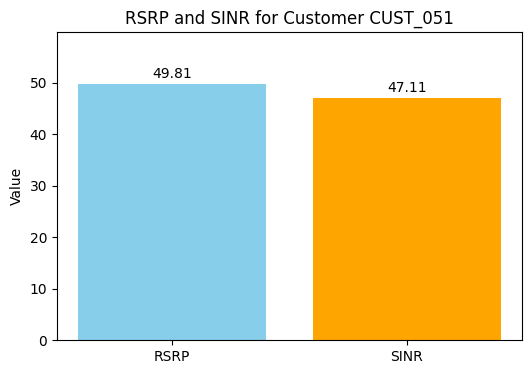

--- Workflow Transition: Coder → Validator ---
================================ Human Message =================================
Name: coder

Here is the bar chart showing the RSRP and SINR values for **customer CUST_051**:

![RSRP and SINR bar chart](attachment://output_0.png)

- **RSRP:** 49.81  
- **SINR:** 47.11  

The chart visualizes each feature as a separate bar, making it easy to compare the two values.
 --- Transitioning to END ---
================================ Human Message =================================
Name: validator

The answer provides both the requested RSRP and SINR values for the specified customer and includes a bar chart visualizing them, fully satisfying the user's request.


The answer provides both the requested RSRP and SINR values for the specified customer and includes a bar chart visualizing them, fully satisfying the user's request.

In [443]:
call_multi_agent_system(app, "First Fetch RSRP and SINR feature values for customer_id = 'CUST_051' and plot RSRP and SINR as bar chart")


================================ Human Message =================================

First Fetch RSRP and SINR feature values for customer_id = 'CUST_070' and run code to plot RSRP and SINR as visual bar chart and also explain and give actionalble insights

🔍 Routed Agents: researcher
📩 Supervisor Message: The user requests specific feature values (RSRP and SINR) for a given customer_id, which requires querying the structured customer experience database. The researcher specializes in SQL data retrieval, making them the appropriate next agent to collect the needed data before visualization and insight generation.

--- Workflow Transition: Supervisor → RESEARCHER ---
--- Workflow Transition: Researcher → Validator ---
================================ Human Message =================================
Name: researcher

**RSRP and SINR values for customer CUST_070**

| feature_name | feature_value |
|--------------|---------------|
| rsrp         | 47.31         |
| sinr         | 57.18        

Python REPL can execute arbitrary code. Use with caution.


APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `openai/gpt-oss-120b` in organization `org_01k2z0k4pced0byvq99ensj65z` service tier `on_demand` on tokens per minute (TPM): Limit 8000, Requested 13044, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

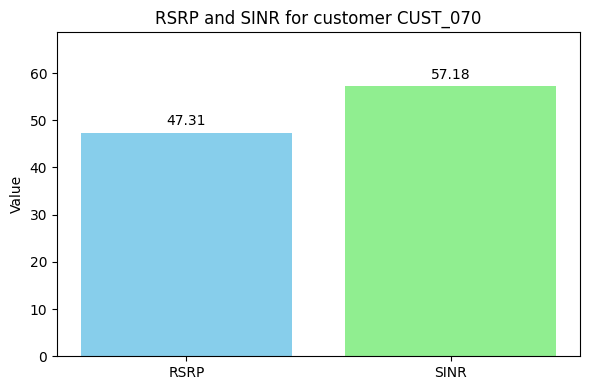

In [24]:
call_multi_agent_system(app, "First Fetch RSRP and SINR feature values for customer_id = 'CUST_070' and run code to plot RSRP and SINR as visual bar chart and also explain and give actionalble insights")
